In [1]:
!ls data

'ls' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [145]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np

def load_abs_surfs():
    abs_surfs = pd.read_excel('data/absSurfs.xlsx').set_index("Site")
    abs_surfs = abs_surfs.stack()
    abs_surfs.index.names = ["Site", "CLC"]
    idx = abs_surfs.index
    abs_surfs.index = abs_surfs.index.set_levels([idx.levels[0].to_series(), idx.levels[1].to_series().astype(int)])
    abs_surfs = pd.DataFrame({'surface': abs_surfs})
    return abs_surfs

def load_pesticides():
    pesticides = pd.read_excel('data/pesticides.xlsx').rename(columns={'importName': 'pesticide'})
    pesticides = pesticides.set_index("pesticide")
    pesticides["typeEN"] = pesticides["typeEN"].str.lower().str.replace("and", ",",regex=True).str.replace(" +", "",regex=True)
    pesticides["familyEN"] = pesticides["familyEN"].str.lower().str.replace(" +", ",",regex=True)
    return pesticides

def load_libelles():
    a = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_1").rename(columns={'code_clc_1': "CLC"})
    b = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_2").rename(columns={'code_clc_2': "CLC"})
    c = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_3").rename(columns={'code_clc_3': "CLC"})
    libelles = pd.concat((a, b, c)).set_index("CLC")
    return libelles

def load_disthive():
    dist_beehive = pd.read_excel('data/distsOneSheet.xlsx').rename(columns={"classCLC": "CLC"}).set_index(["Site", "polyID", "CLC"])
    return dist_beehive

def load_periods(category):
    if category not in ["HM", "Pesticides"]:
        raise ValueError("cateogry can only be HM or Pesticides")
    
    all_data = []
    for year in ["2017", "2018", "2019", "2020"]:
        year_path = f"data/{year}/{category}"
        onlyfiles = [join(year_path, f) for f in listdir(year_path) if isfile(join(year_path, f)) and f.endswith(".xlsx") and not f.startswith('~')]
        for excel in onlyfiles:
            all_data.append(pd.read_excel(excel))
    df = pd.concat(all_data).rename(columns={"REF....SUBSTANCE": "Site", "PERIOD": "Period"})
    df = df.assign(
        Year=df["Period"].apply(lambda x: x.split('/')[0]),
        Quarter=df["Period"].apply(lambda x: x.split('/')[1])
    ).drop('Period', axis=1).set_index(['Site', 'Year', 'Quarter'])
    return df

def load_heavy_metal_lmr():
    lmr = pd.read_csv("data/LMR.txt", sep="\t").drop("Unnamed: 7", axis=1).stack().droplevel(0)
    lmr.index.name = "heavymetal"
    lmr = pd.DataFrame({'LMR': lmr})
    return lmr

def get_pesticides_flags(pesticides_periods, pesticide_cat, pesticides_family, pesticides, thresh=0):
    df = pesticides_periods
    base_index = df.index.names
    df = df.stack()
    # Pesticides
    df.index.names = base_index + ['pesticide']
    site_per_pesticide = df.reset_index().rename(columns={0: 'level'}).set_index('pesticide').merge(pesticides[['LMR']], left_index=True, right_index=True)
    site_per_pesticide = site_per_pesticide.assign(
        above_LMR=site_per_pesticide['level'] > site_per_pesticide['LMR'],
        present=site_per_pesticide['level'] > thresh
    )

    pesticide_cat_per_site = (site_per_pesticide.merge(pesticide_cat, left_index=True, right_index=True).groupby(base_index + ['pesticide_cat']).max())
    pesticide_cat_per_site = pesticide_cat_per_site.unstack()

    pesticide_fam_per_site = (site_per_pesticide.merge(pesticides_family, left_index=True, right_index=True).groupby(base_index + ['pesticide_family']).max())
    pesticide_fam_per_site = pesticide_fam_per_site.unstack()

    site_per_pesticide = site_per_pesticide.reset_index().set_index(base_index + ['pesticide'])

    pesticides_flags = pd.concat(
        [
            site_per_pesticide.unstack(),
            pesticide_cat_per_site,
            pesticide_fam_per_site,
        ],
        axis=1,
        keys=['pesticide', 'pesticide_cat','pesticide_family'],
    )
    return pesticides_flags

def get_heavymetal_flags(heavy_metals_periods, heavy_metal_lmr, thresh=0):
    df = heavy_metals_periods
    base_index = df.index.names
    df = df.stack()
    # Pesticides
    df.index.names = base_index + ["heavymetal"]
    df = df.reset_index().rename(columns={0: 'level'}).set_index('heavymetal')
    df = df.merge(heavy_metal_lmr, left_index=True, right_index=True).reset_index().set_index(base_index + ['heavymetal'])
    df = df.assign(
        above_LMR=df['level'] > df['LMR'],
        present=df['level'] > thresh
    )
    df = df.unstack()
    # Add column level
    df = pd.concat([df], axis=1, keys=['heavymetal'])
    return df

def get_phm_flags(phm, pesticide_cat, pesticides_family, pesticides, heavy_metal_lmr, thresh=0):
    df = pd.concat([
        get_pesticides_flags(phm['pesticide'], pesticide_cat, pesticides_family, pesticides, thresh=thresh),
        get_heavymetal_flags(phm['heavymetal'], heavy_metal_lmr, thresh=thresh),
    ], axis=1)
    # Drop LMR as it's not useful
    df = df.drop(['LMR'], axis=1, level=1)
    return df

def fill_phm_na(phm):
    # This will fill na in the following way:
    # First group by site and year. If a period is missing data for a year,
    # it will then inherit the mean for the periods of that year.
    # If all the periods for a year are nan, then the values will be grouped just by site,
    # and nan will be filled for these by the mean over all the periods of all the years for which there are values.
    # And if finally all values are nan, the value will be 0.
    # Changing mean() by ffill() or bfill() could be an alternative,
    # by setting the values of the previous period/year (ffill) or of the next period/year (bfill)
    new_pesticides = phm['pesticide'].groupby(['Site', 'Year'], sort=False).apply(lambda x: x.fillna(0))
    # Group just by site to replace values that are missing for all periods of a year by the mean of the periods of all years
    new_pesticides = new_pesticides.groupby(['Site'], sort=False).apply(lambda x: x.fillna(0))
    # Same for heavy metals
    new_heavymetal = phm['heavymetal'].groupby(['Site', 'Year'], sort=False).apply(lambda x: x.fillna(0))
    new_heavymetal = new_heavymetal.groupby(['Site'], sort=False).apply(lambda x: x.fillna(0))
    return phm.assign(
        pesticide=new_pesticides,
        heavymetal=new_heavymetal
    )

# Load all the data
heavy_metal_lmr = load_heavy_metal_lmr()
abs_surfs = load_abs_surfs() # Merged later
pesticides = load_pesticides()
libelles = load_libelles()
disthive = load_disthive() # Merged later
heavy_metal_periods = load_periods("HM")
# Merge chromium and chrome
heavy_metal_periods = heavy_metal_periods.fillna(0)
heavy_metal_periods['Chromium'] = heavy_metal_periods['Chromium'] + heavy_metal_periods['Chrome']
heavy_metal_periods = heavy_metal_periods.drop(['Chrome'], axis=1)

pesticides_periods = load_periods("Pesticides")

# Start merging data together

# Average the distances to the hives
distsurf = disthive.groupby(['Site', 'CLC']).mean().merge(abs_surfs, left_index=True, right_index=True)

# Load historical data
phm = pd.concat(
    [pesticides_periods,
    heavy_metal_periods],
    axis=1,
    keys=['pesticide','heavymetal'],
)

phm = fill_phm_na(phm)

# Categorize pesticides
pesticides_family = pd.DataFrame({'pesticide_family': pesticides[["familyEN"]].fillna("UNKNOWN").apply(lambda r: r[0].split(','), axis=1).explode()})
pesticide_cat = pd.DataFrame({'pesticide_cat': pesticides[["typeEN"]].fillna("UNKNOWN").apply(lambda r: r[0].split(','), axis=1).explode()})

# Pesticide and heavy metals flags
phm_flags = get_phm_flags(phm, pesticide_cat, pesticides_family, pesticides, heavy_metal_lmr, thresh=0)

# We've now got basic features and basic things to predict.
# Next steps are to engineer these features, have a look at them and select a subset from the things to predict
features = distsurf.unstack().fillna(0)

# Contains the level, above_LMR, present for the pesticides, pesticides_category, pesticides_family, heavy_metal
to_predict = phm_flags

In [3]:
phm_flags

pesticide                                                 \
                        level                                                  
                    Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin   
Site   Year Quarter                                                            
B0012  2020 P1         0.0048    0.0          0.0           0.0          0.0   
            P2         0.0000    0.0          0.0           0.0          0.0   
            P3         0.0000    0.0          0.0           0.0          0.0   
            P4         0.0000    0.0          0.0           0.0          0.0   
B0017  2017 P1         0.0000    0.0          0.0           0.0          0.0   
...                       ...    ...          ...           ...          ...   
FE0001 2019 P3         0.0000    0.0          0.0           0.0          0.0   
            P4         0.0000    0.0          0.0           0.0          0.0   
       2020 P1         0.0000    0.0          0.0           0.0          0.0   
            P2         0.0000    0.0          0.0           0.0          0.0   
            P3         0.0000    0.0          0.0           0.0          0.0   

                                                               \
                                                                
                    Benalaxyl Benfluralin Benthiavalicarb.iso   
Site   Year Quarter                                             
B0012  2020 P1         0.0000         0.0                 0.0   
            P2         0.0000         0.0                 0.0   
            P3         0.0000         0.0                 0.0   
            P4         0.0000         0.0                 0.0   
B0017  2017 P1         0.0000         0.0                 0.0   
...                       ...         ...                 ...   
FE0001 2019 P3         0.0000         0.0                 0.0   
            P4         0.0000         0.0                 0.0   
       2020 P1         0.0000         0.0                 0.0   
            P2         0.0049         0.0                 0.0   
            P3         0.0000         0.0                 0.0   

                                               ... heavymetal                 \
                                               ...  above_LMR                  
                    Benzovindiflupyr Boscalid  ...    Arsenic Cadmium Copper   
Site   Year Quarter                            ...                             
B0012  2020 P1                   0.0    0.000  ...      False   False  False   
            P2                   0.0    0.000  ...      False   False  False   
            P3                   0.0    0.000  ...      False   False  False   
            P4                   0.0    0.000  ...      False   False  False   
B0017  2017 P1                   0.0    0.000  ...      False   False  False   
...                              ...      ...  ...        ...     ...    ...   
FE0001 2019 P3                   0.0    0.000  ...      False   False  False   
            P4                   0.0    0.000  ...      False   False  False   
       2020 P1                   0.0    0.009  ...      False   False  False   
            P2                   0.0    0.000  ...      False   False  False   
            P3                   0.0    0.000  ...      False   False  False   

                                                                          
                                   present                                
                      Lead Mercury Arsenic Cadmium Copper   Lead Mercury  
Site   Year Quarter                                                       
B0012  2020 P1       False   False    True    True   True   True   False  
            P2       False   False   False    True   True   True   False  
            P3       False   False    True    True   True   True   False  
            P4       False   False    True    True   True   True   False  
B0017  2017 P1       False   False   False

pesticide                                                           \
        present                                                            
      Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin Benalaxyl   
False       528    549          539           520          539       469   
True         22      1           11            30           11        81   

                                                                 ...  \
                                                                 ...   
      Benfluralin Benthiavalicarb.iso Benzovindiflupyr Boscalid  ...   
False         548                 549              548      531  ...   
True            2                   1                2       19  ...   

      pesticide_family                                                       \
               present                                                        
              triazole triazolinthione triazolopyrimidine unclassified urea   
False              489             534                539          530  548   
True                61              16                 11           20    2   

      heavymetal                              
         present                              
         Arsenic Cadmium Copper Lead Mercury  
False        290     119    123  172     529  
True         260     431    427  378      21  

[2 rows x 199 columns]

,heavymetal,pesticide,pesticide_cat,pesticide_family
,present,present,present,present
False,1233,61828,3965,38679
True,1517,872,435,921


pesticide                                                           \
      above_LMR                                                            
      Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin Benalaxyl   
False     550.0  550.0          548         550.0          545       532   
True        0.0    0.0            2           0.0            5        18   

                                                                 ...  \
                                                                 ...   
      Benfluralin Benthiavalicarb.iso Benzovindiflupyr Boscalid  ...   
False       550.0               550.0            550.0      541  ...   
True          0.0                 0.0              0.0        9  ...   

      pesticide_family                                                       \
             above_LMR                                                        
              triazole triazolinthione triazolopyrimidine unclassified urea   
False              539           550.0                548          547  549   
True                11             0.0                  2            3    1   

      heavymetal                              
       above_LMR                              
         Arsenic Cadmium Copper Lead Mercury  
False        549     546    549  544   550.0  
True           1       4      1    6     0.0  

[2 rows x 199 columns]

,heavymetal,pesticide,pesticide_cat,pesticide_family
,above_LMR,above_LMR,above_LMR,above_LMR
False,2738,62528,4290,39431
True,12,172,110,169


Text(0.5, 1.0, 'Heavy metal above_LMR')

<Figure size 432x288 with 0 Axes>

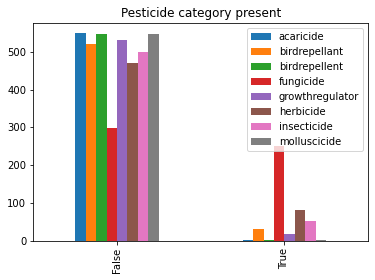

<Figure size 432x288 with 0 Axes>

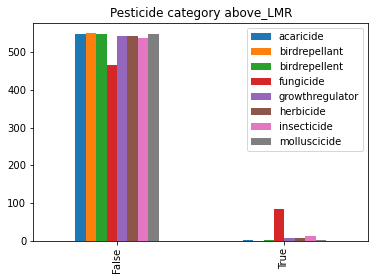

<Figure size 432x288 with 0 Axes>

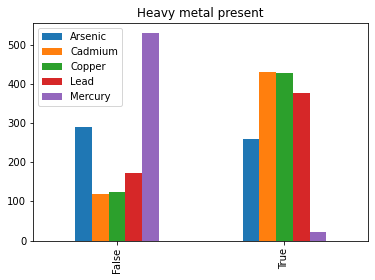

<Figure size 432x288 with 0 Axes>

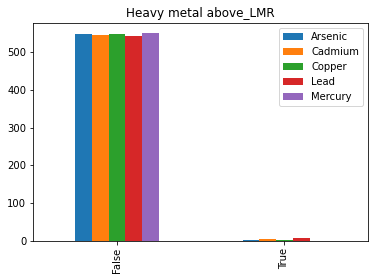

In [4]:
import matplotlib.pyplot as plt
# Look at counts for each category. As you can see, quite unbalanced with a threshold of 0...
idx = pd.IndexSlice
display(phm_flags.loc[:, idx[:, 'present', :]].apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['pesticide_cat', 'present', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Pesticide category present")
display(phm_flags.loc[:, idx[:, 'present', :]].stack().apply(pd.Series.value_counts).fillna(0))
display(phm_flags.loc[:, idx[:, 'above_LMR', :]].apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['pesticide_cat', 'above_LMR', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Pesticide category above_LMR")
display(phm_flags.loc[:, idx[:, 'above_LMR', :]].stack().apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['heavymetal', 'present', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Heavy metal present")
plt.figure()
phm_flags.loc[:, idx['heavymetal', 'above_LMR', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Heavy metal above_LMR")


In [5]:
# Expand the features artifically
def set_year_and_quarter(df, year, quarter):
    new_df = {}
    new_df[year] = df
    df = pd.concat(new_df, names=['Year']).reorder_levels(['Site', 'Year'])
    new_df = {}
    new_df[quarter] = df
    df = pd.concat(new_df, names=['Quarter']).reorder_levels(['Site', 'Year', 'Quarter'])
    return df

def create_history_for_features(features, year, quarter, percent_noise=0.2):
    # Just fetching from a random distribution with some noise here.
    df = features.apply(lambda x: x*np.random.uniform(1-percent_noise, 1+percent_noise, len(x)))
    df = set_year_and_quarter(df, year, quarter)
    return df

def create_fictive_history(features, phm, validation_year_period, percent_noise=0.2):
    # This is generating too much data as not every site has 4 years and 4 periods.
    # But the merge later will take care of that.
    years = list(phm.index.get_level_values('Year').unique())
    quarters = list(phm.index.get_level_values('Quarter').unique())
    all_data = []
    for year in years:
        for quarter in quarters:
            if (year, quarter) in validation_year_period:
                # Use real values
                new_features = set_year_and_quarter(features, year, quarter).assign(DataType="validation")
            else:
                # Use fictive values
                new_features = create_history_for_features(features, year, quarter, percent_noise=percent_noise).assign(DataType="training")
            new_features.reset_index().set_index(new_features.index.names + ['DataType'])
            all_data.append(new_features)
    return pd.concat(all_data, axis=0)

validation_year_period = [("2020", "P1"), ("2020", "P2"), ("2020", "P3"), ("2020", "P4")]
fictive = create_fictive_history(features, phm_flags, validation_year_period)
fictive

dist                                             \
CLC                          111         112          121          122  123   
Site   Year Quarter                                                           
B0012  2020 P1       1020.033273  564.609800   117.220148     0.000000  0.0   
B0017  2020 P1          0.000000  230.733942  1457.209438     0.000000  0.0   
B0019  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
B0021  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
B0023  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
...                          ...         ...          ...          ...  ...   
F0069  2019 P4          0.000000  826.285311     0.000000     0.000000  0.0   
F0071  2019 P4          0.000000    0.000000  1086.630675     0.000000  0.0   
F0073  2019 P4          0.000000    0.000000     0.000000     0.000000  0.0   
F0075  2019 P4          0.000000  776.052518   277.768299  1495.917195  0.0   
FE0001 2019 P4          0.000000    0.000000     0.000000     0.000000  0.0   

                                                             ...  \
CLC                  124         131  133  141          142  ...   
Site   Year Quarter                                          ...   
B0012  2020 P1       0.0     0.00000  0.0  0.0     0.000000  ...   
B0017  2020 P1       0.0     0.00000  0.0  0.0     0.000000  ...   
B0019  2020 P1       0.0     0.00000  0.0  0.0     0.000000  ...   
B0021  2020 P1       0.0     0.00000  0.0  0.0     0.000000  ...   
B0023  2020 P1       0.0     0.00000  0.0  0.0  1223.368654  ...   
...                  ...         ...  ...  ...          ...  ...   
F0069  2019 P4       0.0     0.00000  0.0  0.0  1276.657609  ...   
F0071  2019 P4       0.0  1258.14016  0.0  0.0     0.000000  ...   
F0073  2019 P4       0.0     0.00000  0.0  0.0     0.000000  ...   
F0075  2019 P4       0.0     0.00000  0.0  0.0     0.000000  ...   
FE0001 2019 P4       0.0     0.00000  0.0  0.0     0.000000  ...   

                          surface                                             \
CLC                           313  322           324  331           412  423   
Site   Year Quarter                                                            
B0012  2020 P1       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
B0017  2020 P1       1.871540e+06  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
B0019  2020 P1       1.330174e+06  0.0  0.000000e+00  0.0  3.786370e+05  0.0   
B0021  2020 P1       3.620488e+06  0.0  0.000000e+00  0.0  9.421463e+05  0.0   
B0023  2020 P1       6.865176e+04  0.0  6.979889e+05  0.0  1.809062e+06  0.0   
...                           ...  ...           ...  ...           ...  ...   
F0069  2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
F0071  2019 P4       0.000000e+00  0.0  7.110161e+05  0.0  0.000000e+00  0.0   
F0073  2019 P4       8.017289e+03  0.0  1.681825e+06  0.0  0.000000e+00  0.0   
F0075  2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
FE0001 2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   

                                                         DataType  
CLC                            511           512  523              
Site   Year Quarter                                                
B0012  2020 P1       486328.326111       0.00000  0.0  validation  
B0017  2020 P1            0.000000       0.00000  0.0  validation  
B0019  2020 P1            0.000000       0.00000  0.0  validation  
B0021  2020 P1            0.000000       0.00000  0.0  validation  
B0023  2020 P1            0.000000       0.00000  0.0  validation  
...                            ...           ...  ...         ...  
F0069  2019 P4            0.000000       0.00000  0.0    training  
F0071  2019 P4            0.000000  586688.76018  0.0    training  
F0073  2019 P4            0.000000       0.00000  0.0    training  
F0075  2019 P4            0.000

In [6]:
def get_full_dataset(fictive, phm_flags):
    # Add column level
    fictive_p = pd.concat([fictive], axis=1, keys=['features'])
    # Twice because the number of levels for features and target must be equal to be able to merge them
    fictive_p = pd.concat([fictive_p], axis=1, keys=['features'])
    target_p = pd.concat([phm_flags], axis=1, keys=['target'])
    # This will remove the (year, quarter) pairs from the fictive dataset that don't actually exist as measurements for a site
    full_dataset = fictive_p.merge(target_p, left_index=True, right_index=True)
    # Full dataset containing the features and the targets.
    full_dataset = full_dataset.reset_index().set_index(['Site','Year', 'Quarter', ('features', 'features', 'DataType')])
    full_dataset.index.names = full_dataset.index.names[:-1] + ['DataType']
    return full_dataset

full_dataset = get_full_dataset(fictive, phm_flags)
full_dataset

C:\Users\Guillaume\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
C:\Users\Guillaume\anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


features                            \
                                   features                             
                                       dist                             
CLC                                     111          112          121   
Site   Year Quarter DataType                                            
B0012  2020 P1      validation  1020.033273   564.609800   117.220148   
B0017  2020 P1      validation     0.000000   230.733942  1457.209438   
B0019  2020 P1      validation     0.000000     0.000000     0.000000   
B0021  2020 P1      validation     0.000000     0.000000     0.000000   
B0023  2020 P1      validation     0.000000     0.000000     0.000000   
...                                     ...          ...          ...   
F0035  2019 P4      training       0.000000     0.000000     0.000000   
F0039  2019 P4      training       0.000000  1659.575346   828.895614   
F0041  2019 P4      training       0.000000     0.000000     0.000000   
F0043  2019 P4      training       0.000000   752.316801   739.759705   
FE0001 2019 P4      training       0.000000     0.000000     0.000000   

                                                                               \
                                                                                
                                                                                
CLC                                    122  123         124  131          133   
Site   Year Quarter DataType                                                    
B0012  2020 P1      validation    0.000000  0.0    0.000000  0.0     0.000000   
B0017  2020 P1      validation    0.000000  0.0    0.000000  0.0     0.000000   
B0019  2020 P1      validation    0.000000  0.0    0.000000  0.0     0.000000   
B0021  2020 P1      validation    0.000000  0.0    0.000000  0.0     0.000000   
B0023  2020 P1      validation    0.000000  0.0    0.000000  0.0     0.000000   
...                                    ...  ...         ...  ...          ...   
F0035  2019 P4      training      0.000000  0.0    0.000000  0.0     0.000000   
F0039  2019 P4      training    944.546610  0.0    0.000000  0.0  1186.331359   
F0041  2019 P4      training    312.192091  0.0    0.000000  0.0     0.000000   
F0043  2019 P4      training      0.000000  0.0  670.423939  0.0     0.000000   
FE0001 2019 P4      training      0.000000  0.0    0.000000  0.0     0.000000   

                                                         ...     target  \
                                                         ... heavymetal   
                                                         ...  above_LMR   
CLC                                    141          142  ...    Arsenic   
Site   Year Quarter DataType                             ...              
B0012  2020 P1      validation    0.000000     0.000000  ...      False   
B0017  2020 P1      validation    0.000000     0.000000  ...      False   
B0019  2020 P1      validation    0.000000     0.000000  ...      False   
B0021  2020 P1      validation    0.000000     0.000000  ...      False   
B0023  2020 P1      validation    0.000000  1223.368654  ...      False   
...                                    ...          ...  ...        ...   
F0035  2019 P4      training      0.000000     0.000000  ...      False   
F0039  2019 P4      training      0.000000     0.000000  ...      False   
F0041  2019 P4      training    655.226266  1350.843301  ...      False   
F0043  2019 P4      training      0.000000  1019.501845  ...      False   
FE0001 2019 P4      training      0.000000     0.000000  ...      False   

                                                                              \
                                                                               
                                                             present           
CLC                            Cadmium Copper   Lead Mercury Arsenic Cadmium   
Site   Year Quarter DataType                    

In [7]:
# Just a quick dirty test.
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_train = full_dataset["features"].loc(axis=0)[:, :, :, "training"]
X_test = full_dataset["features"].loc(axis=0)[:, :, :, 'validation']
Y_train = sub_target.loc(axis=0)[:, :, :, 'training']
Y_test = sub_target.loc(axis=0)[:, :, :, 'validation']

from sklearn.svm import SVC
from sklearn.metrics import classification_report
clf = SVC()
clf.fit(X_train, Y_train)

print(classification_report(clf.predict(X_test), Y_test))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99       194
        True       0.00      0.00      0.00         0

    accuracy                           0.98       194
   macro avg       0.50      0.49      0.50       194
weighted avg       1.00      0.98      0.99       194



C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Correlation matrix

In [51]:
features = full_dataset["features"].loc(axis=1)["features", 'surface', :,:]
features

features                                       \
                                 surface                                        
CLC                                  111        112        121       122  123   
Site   Year Quarter DataType                                                    
B0012  2020 P1      validation 213419.50 3756404.97 2068584.69      0.00 0.00   
B0017  2020 P1      validation      0.00 1755394.82    3380.72      0.00 0.00   
B0019  2020 P1      validation      0.00       0.00       0.00      0.00 0.00   
B0021  2020 P1      validation      0.00       0.00       0.00      0.00 0.00   
B0023  2020 P1      validation      0.00       0.00       0.00      0.00 0.00   
...                                  ...        ...        ...       ...  ...   
F0035  2019 P4      training        0.00       0.00       0.00      0.00 0.00   
F0039  2019 P4      training        0.00   44959.57  391617.94 229934.16 0.00   
F0041  2019 P4      training        0.00       0.00 3195212.08 305192.84 0.00   
F0043  2019 P4      training        0.00 1338535.54  909280.95      0.00 0.00   
FE0001 2019 P4      training        0.00  413547.56       0.00      0.00 0.00   

                                                                             \
                                                                              
CLC                                   124  131      133       141       142   
Site   Year Quarter DataType                                                  
B0012  2020 P1      validation       0.00 0.00     0.00      0.00      0.00   
B0017  2020 P1      validation       0.00 0.00     0.00      0.00      0.00   
B0019  2020 P1      validation       0.00 0.00     0.00      0.00      0.00   
B0021  2020 P1      validation       0.00 0.00     0.00      0.00      0.00   
B0023  2020 P1      validation       0.00 0.00     0.00      0.00 194534.06   
...                                   ...  ...      ...       ...       ...   
F0035  2019 P4      training         0.00 0.00     0.00      0.00      0.00   
F0039  2019 P4      training         0.00 0.00 40695.70      0.00      0.00   
F0041  2019 P4      training         0.00 0.00     0.00 418337.02  24818.07   
F0043  2019 P4      training   1026088.80 0.00     0.00      0.00 191419.90   
FE0001 2019 P4      training         0.00 0.00     0.00      0.00      0.00   

                                ...                                            \
                                ...                                             
CLC                             ...        312        313  322       324  331   
Site   Year Quarter DataType    ...                                             
B0012  2020 P1      validation  ...       0.00       0.00 0.00      0.00 0.00   
B0017  2020 P1      validation  ... 1097484.27 1871539.63 0.00      0.00 0.00   
B0019  2020 P1      validation  ... 5146666.34 1330174.08 0.00      0.00 0.00   
B0021  2020 P1      validation  ... 1572155.90 3620487.67 0.00      0.00 0.00   
B0023  2020 P1      validation  ... 2538647.25   68651.76 0.00 697988.90 0.00   
...                             ...        ...        ...  ...       ...  ...   
F0035  2019 P4      training    ...  936820.16  251617.65 0.00  15648.03 0.00   
F0039  2019 P4      training    ...       0.00  324711.79 0.00      0.00 0.00   
F0041  2019 P4      training    ...       0.00       0.00 0.00      0.00 0.00   
F0043  2019 P4      training    ...       0.00       0.00 0.00      0.00 0.00   
FE0001 2019 P4      training    ...       0.00       0.00 0.00      0.00 0.00   

                                                                    
                                                                    
CLC                                   412  423       511  512  523  
Site   Year Quarter DataType                                        
B0012  2020 P1      validation       0.00 0.00 486328.33 0.00 0.00  
B0017  2020 P1      validation       0.00 0.00      0.00 0.00 0.00  


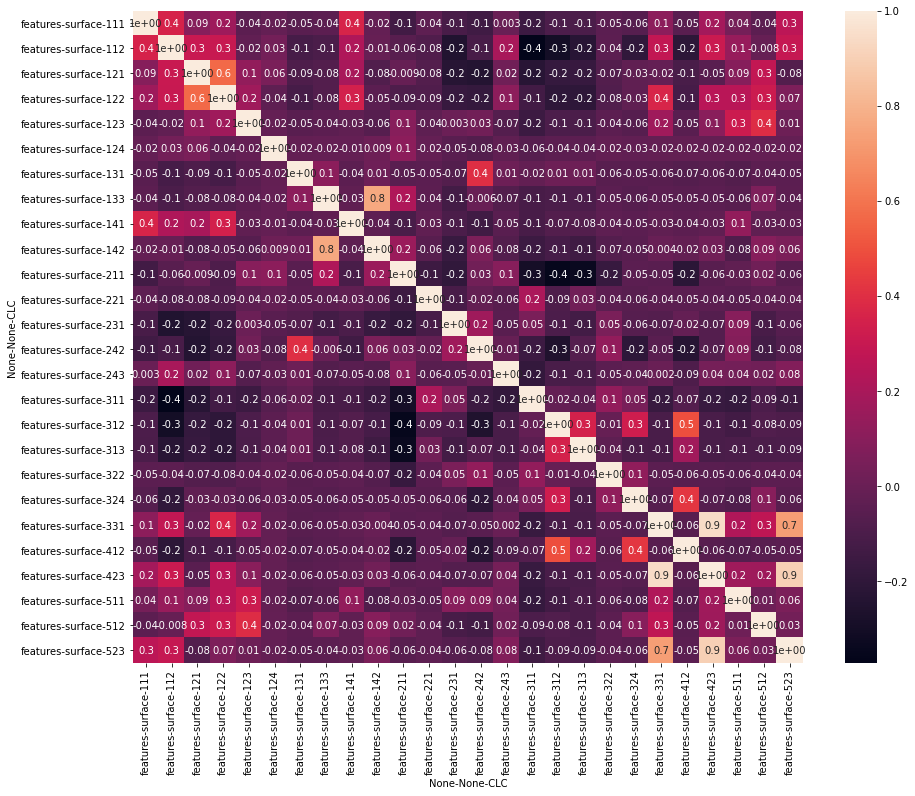

In [52]:
import seaborn as sns
corrMatrix = features.corr()
fig_dims = (15, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(corrMatrix, annot=True, fmt='.1', ax = ax)
plt.show()

#### PCA

In [9]:
#heavy_metal_periods['Lead'].mean() 0.221
#heavy_metal_periods['Cadmium'].mean() 0.187
#heavy_metal_periods['Arsenic'].mean() 0.037
#heavy_metal_periods['Mercury'].mean() 0.0004
#heavy_metal_periods['Copper'].mean() 7.972
#heavy_metal_periods['Chromium'].mean() 0.105
#heavy_metal_periods['Zinc'].mean() 38.68

In [73]:
X_train = full_dataset["features"].loc(axis=0)[:, :, :, 'training']
X_test = full_dataset["features"].loc(axis=0)[:, :, :, 'validation']

In [81]:
X_train

features                                          \
                                 dist                                           
CLC                               111     112     121    122  123    124  131   
Site   Year Quarter DataType                                                    
B0017  2017 P1      training     0.00  250.56 1519.31   0.00 0.00   0.00 0.00   
B0019  2017 P1      training     0.00    0.00    0.00   0.00 0.00   0.00 0.00   
B0021  2017 P1      training     0.00    0.00    0.00   0.00 0.00   0.00 0.00   
B0023  2017 P1      training     0.00    0.00    0.00   0.00 0.00   0.00 0.00   
B0037  2017 P1      training     0.00  137.88    0.00   0.00 0.00   0.00 0.00   
...                               ...     ...     ...    ...  ...    ...  ...   
F0035  2019 P4      training     0.00    0.00    0.00   0.00 0.00   0.00 0.00   
F0039  2019 P4      training     0.00 1659.58  828.90 944.55 0.00   0.00 0.00   
F0041  2019 P4      training     0.00    0.00    0.00 312.19 0.00   0.00 0.00   
F0043  2019 P4      training     0.00  752.32  739.76   0.00 0.00 670.42 0.00   
FE0001 2019 P4      training     0.00    0.00    0.00   0.00 0.00   0.00 0.00   

                                                     ...             \
                                                     ...    surface   
CLC                              133    141     142  ...        312   
Site   Year Quarter DataType                         ...              
B0017  2017 P1      training    0.00   0.00    0.00  ... 1141894.98   
B0019  2017 P1      training    0.00   0.00    0.00  ... 4933545.63   
B0021  2017 P1      training    0.00   0.00    0.00  ... 1670362.16   
B0023  2017 P1      training    0.00   0.00 1342.00  ... 2191900.62   
B0037  2017 P1      training    0.00   0.00  648.92  ...   35852.69   
...                              ...    ...     ...  ...        ...   
F0035  2019 P4      training    0.00   0.00    0.00  ...  936820.16   
F0039  2019 P4      training 1186.33   0.00    0.00  ...       0.00   
F0041  2019 P4      training    0.00 655.23 1350.84  ...       0.00   
F0043  2019 P4      training    0.00   0.00 1019.50  ...       0.00   
FE0001 2019 P4      training    0.00   0.00    0.00  ...       0.00   

                                                                             \
                                                                              
CLC                                 313  322       324  331        412  423   
Site   Year Quarter DataType                                                  
B0017  2017 P1      training 1987893.27 0.00      0.00 0.00       0.00 0.00   
B0019  2017 P1      training 1081104.26 0.00      0.00 0.00  320226.95 0.00   
B0021  2017 P1      training 3159117.20 0.00      0.00 0.00  797591.46 0.00   
B0023  2017 P1      training   64653.83 0.00 661766.00 0.00 1584101.69 0.00   
B0037  2017 P1      training  269210.42 0.00      0.00 0.00       0.00 0.00   
...                                 ...  ...       ...  ...        ...  ...   
F0035  2019 P4      training  251617.65 0.00  15648.03 0.00       0.00 0.00   
F0039  2019 P4      training  324711.79 0.00      0.00 0.00       0.00 0.00   
F0041  2019 P4      training       0.00 0.00      0.00 0.00       0.00 0.00   
F0043  2019 P4      training       0.00 0.00      0.00 0.00       0.00 0.00   
FE0001 2019 P4      training       0.00 0.00      0.00 0.00       0.00 0.00   

                                             
                                             
CLC                           511  512  523  
Site   Year Quarter DataType                 
B0017  2017 P1      training 0.00 0.00 0.00  
B0019  2017 P1      training 0.00 0.00 0.00  
B0021  2017 P1      training 0.00 0.00 0.00  
B0023  2017 P1      training 0.00 0.00 0.00  
B0037  2017 P1      training 0.00 0.00 0.00  
...                           ...  ...  ...  
F0035  2019 P4      training 0.00 0.00 0.00  
F0039  2019 P4      training 0.00 0.00 0.00  
F0041  20

In [11]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [13]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([1.50782518e-01, 8.12109393e-02, 7.29454478e-02, 6.62971792e-02,
       5.94461444e-02, 4.68038464e-02, 4.46041181e-02, 4.22329580e-02,
       4.10244983e-02, 3.81197050e-02, 3.50682745e-02, 3.14809023e-02,
       2.96403213e-02, 2.77304226e-02, 2.40958621e-02, 2.19684943e-02,
       2.05006220e-02, 1.78116274e-02, 1.68571142e-02, 1.54583087e-02,
       1.30787243e-02, 1.24340740e-02, 1.08884441e-02, 1.03092307e-02,
       9.43753579e-03, 8.48126505e-03, 8.13421127e-03, 7.10425447e-03,
       5.37605622e-03, 4.98694553e-03, 4.40693429e-03, 3.28218971e-03,
       3.10531977e-03, 2.65968586e-03, 2.44033917e-03, 2.05488852e-03,
       1.46219682e-03, 1.28173006e-03, 1.09876240e-03, 6.81796626e-04,
       4.99386430e-04, 4.19051355e-04, 3.66791313e-04, 3.23170783e-04,
       3.01683632e-04, 2.89093403e-04, 2.64056060e-04, 2.25322900e-04,
       1.98987607e-04, 1.43038858e-04, 1.08580832e-04, 7.69484385e-05])

<function matplotlib.pyplot.show(close=None, block=None)>

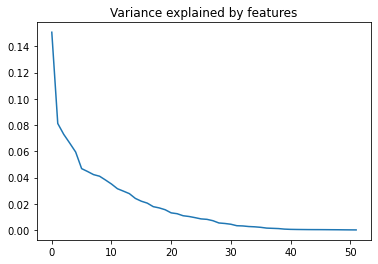

In [14]:
plt.plot(explained_variance)
plt.title("Variance explained by features")
plt.show

In [15]:
explained_variance[0:30].sum()

0.9743100451755262

#### Lazy processing - Heavy metal/above_LMR/Lead

In [16]:
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_train = full_dataset["features"].loc(axis=0)[:, :, :, 'training']
X_test = full_dataset["features"].loc(axis=0)[:, :, :, 'validation']
y_train = sub_target.loc(axis=0)[:, :, :, 'training']
y_test = sub_target.loc(axis=0)[:, :, :, 'validation']

In [17]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [18]:
y_train.target.heavymetal.above_LMR.Lead.value_counts()

False    353
True     105
Name: Lead, dtype: int64

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components=35)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [131]:
pca_df = pd.DataFrame(pca.components_)

In [20]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
100%|██████████| 30/30 [00:00<00:00, 41.72it/s]

[08:52:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)

neigh.fit(X_train, y_train)

y_pred_knn = neigh.predict(X_test)

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       191
        True       0.33      0.33      0.33         3

    accuracy                           0.98       194
   macro avg       0.66      0.66      0.66       194
weighted avg       0.98      0.98      0.98       194



#### Cross validation

In [24]:
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_cv = full_dataset["features"]
y_cv = sub_target

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

sm = SMOTE(random_state=42, sampling_strategy=0.2, k_neighbors=2)
X_cv, y_cv = sm.fit_resample(X_cv, y_cv)

clf_forest=RandomForestClassifier(n_estimators=100, random_state=42)
scores_randfor = cross_val_score(clf_forest, X_cv, y_cv, cv=10, scoring="f1")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_randfor.mean(), scores_randfor.std()))

0.98 accuracy with a standard deviation of 0.03


In [26]:
scores_randfor

array([0.90909091, 0.95652174, 0.95238095, 0.95238095, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

### Predict Presence of heavy metal

In [173]:
target_presence_hm = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['present']]]
target_presence_hm

target                              
                               heavymetal                              
                                  present                              
CLC                               Arsenic Cadmium Copper   Lead Mercury
Site   Year Quarter DataType                                           
B0012  2020 P1      validation       True    True   True   True   False
B0017  2020 P1      validation      False    True   True   True   False
B0019  2020 P1      validation      False    True   True   True   False
B0021  2020 P1      validation      False    True   True   True   False
B0023  2020 P1      validation       True    True   True   True   False
...                                   ...     ...    ...    ...     ...
F0035  2019 P4      training        False   False  False  False   False
F0039  2019 P4      training        False   False  False  False   False
F0041  2019 P4      training         True    True   True   True   False
F0043  2019 P4      training         True    True   True   True   False
FE0001 2019 P4      training        False    True   True  False   False

[550 rows x 5 columns]

In [176]:
def presence_hm(x):
    idx = pd.IndexSlice
    if (x["target", "heavymetal", "present", "Arsenic"] == False and
        x["target", "heavymetal", "present", "Cadmium"] == False and 
        x["target", "heavymetal", "present", "Copper"] == False and 
        x["target", "heavymetal", "present", "Lead"] == False and 
        x["target", "heavymetal", "present", "Mercury"] == False):
        
        return False
    
    else:
        
        return True

In [177]:
idx = pd.IndexSlice
target_presence_hm["target", "heavymetal", "present", "hm_present"] = target_presence_hm.apply(presence_hm, axis=1)
target_presence_hm

target                                \
                               heavymetal                                 
                                  present                                 
CLC                               Arsenic Cadmium Copper   Lead Mercury   
Site   Year Quarter DataType                                              
B0012  2020 P1      validation       True    True   True   True   False   
B0017  2020 P1      validation      False    True   True   True   False   
B0019  2020 P1      validation      False    True   True   True   False   
B0021  2020 P1      validation      False    True   True   True   False   
B0023  2020 P1      validation       True    True   True   True   False   
...                                   ...     ...    ...    ...     ...   
F0035  2019 P4      training        False   False  False  False   False   
F0039  2019 P4      training        False   False  False  False   False   
F0041  2019 P4      training         True    True   True   True   False   
F0043  2019 P4      training         True    True   True   True   False   
FE0001 2019 P4      training        False    True   True  False   False   

                                           
                                           
                                           
CLC                            hm_present  
Site   Year Quarter DataType               
B0012  2020 P1      validation       True  
B0017  2020 P1      validation       True  
B0019  2020 P1      validation       True  
B0021  2020 P1      validation       True  
B0023  2020 P1      validation       True  
...                                   ...  
F0035  2019 P4      training        False  
F0039  2019 P4      training        False  
F0041  2019 P4      training         True  
F0043  2019 P4      training         True  
FE0001 2019 P4      training         True  

[550 rows x 6 columns]

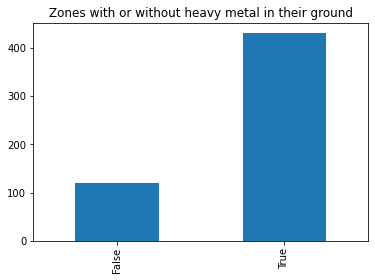

In [179]:
target_presence_hm["target", "heavymetal", "present", "hm_present"].value_counts().plot(kind="bar")
plt.title("Zones with or without heavy metal in their ground")
plt.show()

In [189]:
features_presence_hm = full_dataset["features"]

In [224]:
X_train_presence_hm = features_presence_hm.loc(axis=0)[:, :, :, 'training']
X_test_presence_hm = features_presence_hm.loc(axis=0)[:, :, :, 'validation']
y_train_presence_hm = target_presence_hm.loc(axis=0)[:, :, :, 'training']
y_test_presence_hm = target_presence_hm.loc(axis=0)[:, :, :, 'validation']
y_train_presence_hm = y_train_presence_hm["target", "heavymetal", "present", "hm_present"]
y_test_presence_hm = y_test_presence_hm["target", "heavymetal", "present", "hm_present"]

In [225]:
sc = StandardScaler()
X_train_presence_hm = sc.fit_transform(X_train_presence_hm)
X_test_presence_hm = sc.transform(X_test_presence_hm)

In [221]:
sm = SMOTE(random_state=42, sampling_strategy=0.6)
X_train_presence_hm, y_train_presence_hm = sm.fit_resample(X_train_presence_hm, y_train_presence_hm)

In [226]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,random_state=42)

clf.fit(X_train_presence_hm, y_train_presence_hm)

y_pred_rf = neigh.predict(X_test_presence_hm)

In [227]:
from sklearn.metrics import classification_report

print(classification_report(y_test_presence_hm,y_pred_rf))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        43
        True       0.78      1.00      0.88       151

    accuracy                           0.78       194
   macro avg       0.39      0.50      0.44       194
weighted avg       0.61      0.78      0.68       194



#### Predict if Arsenic is present

In [230]:
target_data_arsenic = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['present'] and c[3] == 'Arsenic']]
target_data_arsenic

,,,,target
,,,,heavymetal
,,,,present
,,,CLC,Arsenic
Site,Year,Quarter,DataType,
B0012,2020,P1,validation,True
B0017,2020,P1,validation,False
B0019,2020,P1,validation,False
B0021,2020,P1,validation,False
B0023,2020,P1,validation,True
...,...,...,...,...
